
stats about:
    - O1-O2 distance(x-axis), time(y-axis)
    - calculate distribution of shared-distance. vs. non-shared
    
    探索什么样的需求，能完成shared订单特征, distribution of O1-O2 distance.
    支持拼车的论点
    估计潜力，车辆需求的减少。
    


In [45]:
import numpy as np
import pandas as pd
from haversine import haversine
from math import radians, cos, sin, asin, sqrt
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn import cluster as cl
from sklearn import metrics
import shapefile
import seaborn as sns
from itertools import combinations as comb
sns.set_style("whitegrid")

## Load Data - 3 days Taxi & Gulf

In [63]:
days = [22,23,24]
frames=[]
types=["taxi","gulf"]
for type in types:
    for day in days:
        path ='/Users/serenazhang/Desktop/didi_project/github/order_data/order_sh_{0}_{1}.csv'.format(day,type)
        col=['order_id','ox','oy',
                        'dx','dy','o_time','d_time','type','label']
        frame = pd.read_csv(path,sep=",",usecols=[0,4,5,6,7,8,9,10,11],header=0, names=col)
        frames.append(frame)
df= pd.concat(frames)
df=df.reset_index(drop=True)

In [70]:
#add column "cnt_of_same_trip" for number of occurence of same label given label number
df['cnt_of_same_trip'] = df.groupby(['label'])["label"].transform('count')
df.loc[df.cnt_of_same_trip>3,'cnt_of_same_trip']=0
#changing time column to datetime object
df['o_time'] = pd.to_datetime(df['o_time'])
df=df[df["d_time"]!="0000-00-00 00:00:00"]
df['d_time'] = pd.to_datetime(df['d_time'])
df[["ox","oy","dx","dy"]]=df[["ox","oy","dx","dy"]].astype(float)

In [71]:
#assign O1,O2,O3 etc
df["shared_order"]=0
gr = df.loc[df["label"]!=0].sort_values('o_time').groupby('label')
df.loc[df["label"]!=0,'shared_order'] = gr.cumcount()

In [14]:
# function for haversine distance
def dis(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine公式
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # 地球平均半径，单位为公里
    return c * r * 1000

# Approaches: DBSCAN, Bruteforce, K-means

In [82]:
# bruteforce function (can be applied to raw data or clustered data)
def brute(df):
    df_shared=df[df["cnt_of_same_trip"]>1]
    df_non=df[df["label"]==0]
    df_shared["sim_id"]=0
    count=0
    for i, row in df_shared.iterrows():
        if count%20==0:
            print(count)
        ox=row["ox"]
        oy=row["oy"]
        dx=row["dx"]
        dy=row["dy"]
        for j, rowj in df_non.iterrows():
            '''
            #Finding some upper bound to reduce runtime (e.g. 1 degree ~ 500 meters)
            if ox-rowj["ox"]>1:
                break
            if dx-rowj["dx"]>1:
                break
            '''
            if dis(ox,oy,rowj["ox"],rowj["oy"])<500:
                if dis(dx,dy,rowj["dx"],rowj["dy"])<500:
                    row["sim_id"]=rowj["order_id"]
                    print(i)
                    break
        count+=1


In [15]:
#DBSCAN function
def df_dbscan(df,ep,c1,c2):
    df_m=df.as_matrix(columns={c1,c2})
    #set up DBSCAN parameters
    kms_per_radian = 6371.0088
    epsilon = ep / kms_per_radian
    db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(df_m))
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([df_m[cluster_labels == n] for n in range(num_clusters)])
    print('Number of clusters: {}'.format(num_clusters))
    %matplitlib inline
    #plot
    unique_labels=set(cluster_labels)
    colors=[plt.cm.Spectral(each) for each in np.linspace(0,1,len(unique_labels))]
    fig, ax = plt.subplots(figsize=[10, 6])
    for k,col in zip(unique_labels,colors):
        if k ==-1:
            continue
        plt.plot(clusters[k][:,0], clusters[k][:,1], "o", markerfacecolor=tuple(col), alpha=0.9, markersize=2)

    ax.set_title('Full data set by start lat long')
    ax.set_xlabel('latitude')
    ax.set_ylabel('longitude')
    df_processed = df.copy()
    df_processed['Cluster'] = pd.Series(cluster_labels, index=df_processed.index)
    return df_processed

In [55]:
#K-means function
def df_kmeans(df,k,c1,c2):
    kmeans = cl.KMeans(n_clusters=k)
    df_m=df.as_matrix(columns={c1,c2})
    kmeans.fit(df_m)
    cluster_labels = kmeans.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([df_m[cluster_labels == n] for n in range(num_clusters)])
    centers = np.array(kmeans.cluster_centers_)
    #plot
    unique_labels=set(cluster_labels)
    colors=[plt.cm.Spectral(each) for each in np.linspace(0,1,len(unique_labels))]
    fig, ax = plt.subplots(figsize=[10, 6])
    for k,col in zip(unique_labels,colors):
        if k ==-1:
            continue
        plt.plot(clusters[k][:,0], clusters[k][:,1], "o", markerfacecolor=tuple(col), alpha=0.9, markersize=2)

    ax.set_title('Full data set by start lat long')
    ax.set_xlabel('latitude')
    ax.set_ylabel('longitude')
    #ax.legend([df_scatter], ['Full set'], loc='upper right')
    plt.show()
    df_processed = df.copy()
    df_processed['Cluster'] = pd.Series(cluster_labels, index=df_processed.index)
    
    return df_processed

In [37]:
def plot_points(dataframe):
    fig, ax = plt.subplots(1,figsize=[10, 6])
    ax=plt.scatter(dataframe["oy"],dataframe["ox"])
    plt.show()

Number of clusters: 137


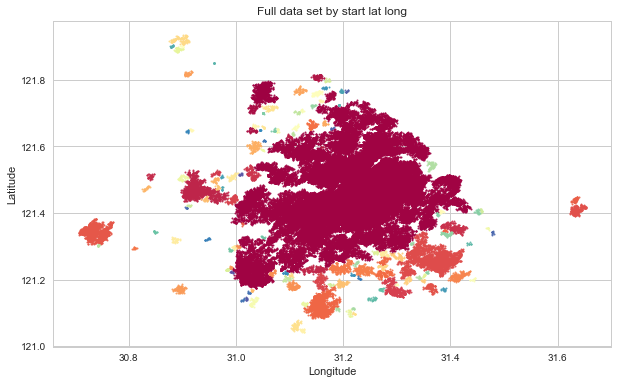

In [22]:
df1=df_dbscan(df,0.5,"ox","oy")

(208371, 11)


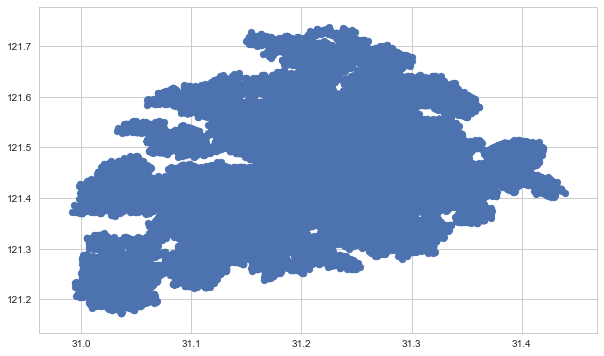

In [80]:
df_main=df1[df1["Cluster"]==1]
print(df_main.shape)
plot_points(df_main)

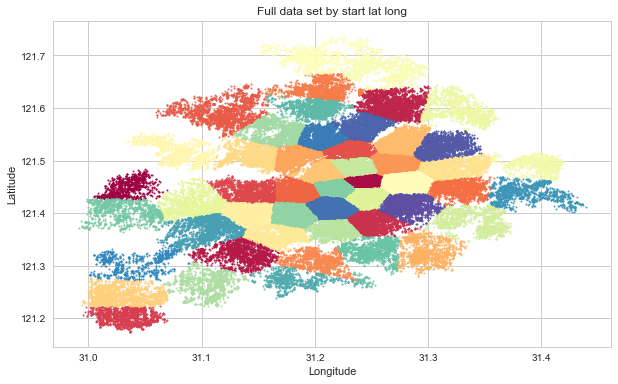

In [50]:
df_k=df_kmeans(df_main,50,"ox","oy")

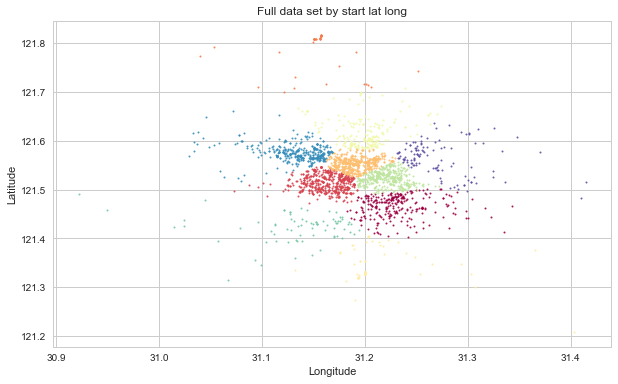

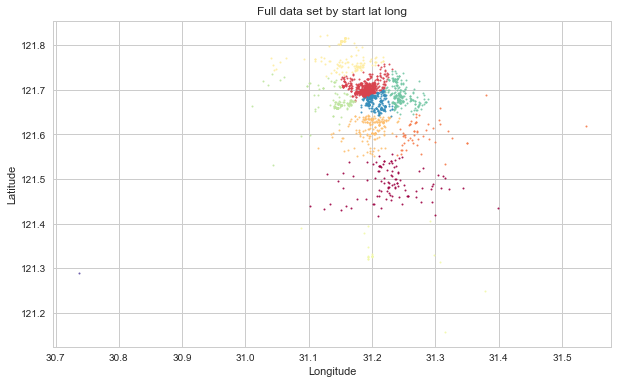

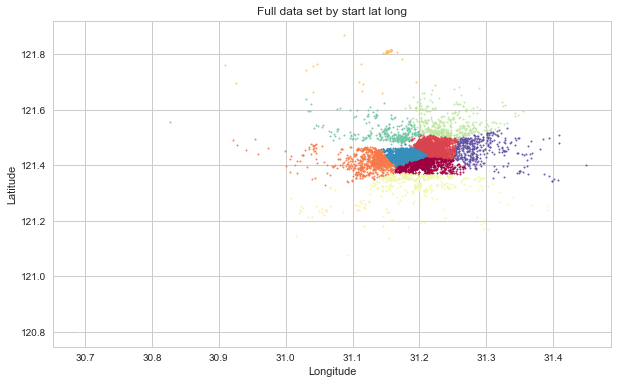

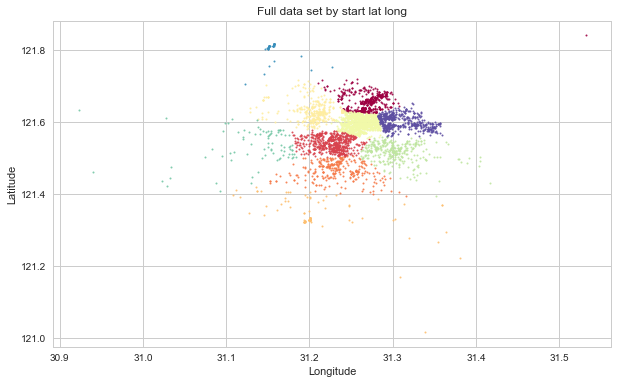

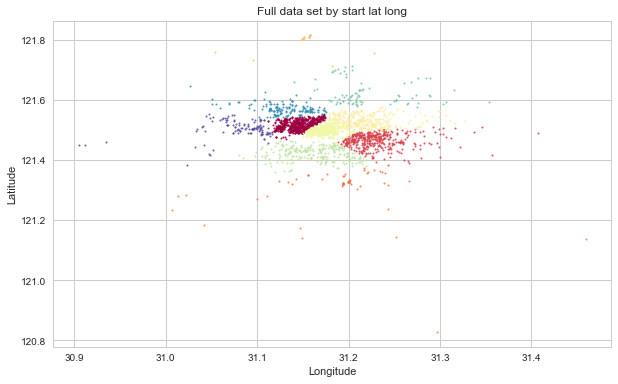

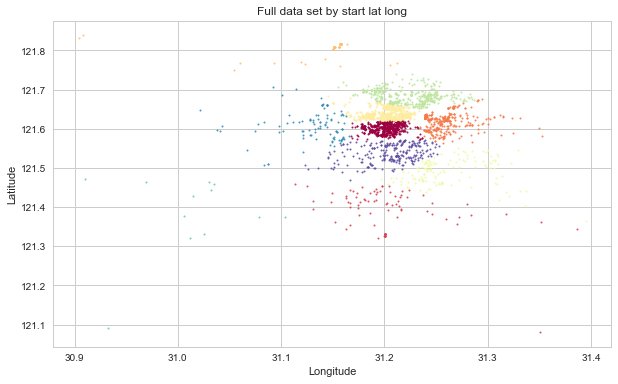

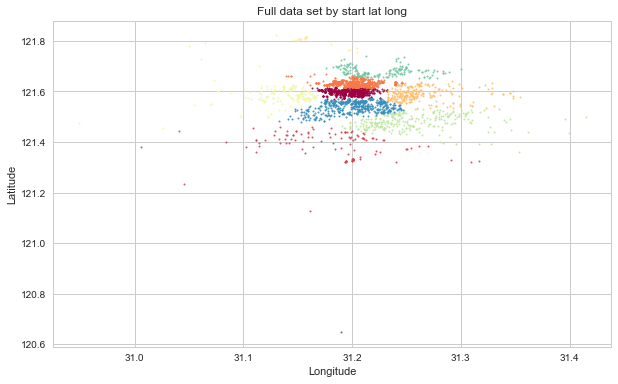

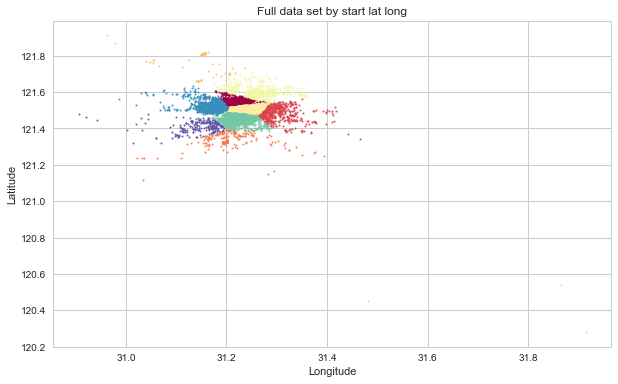

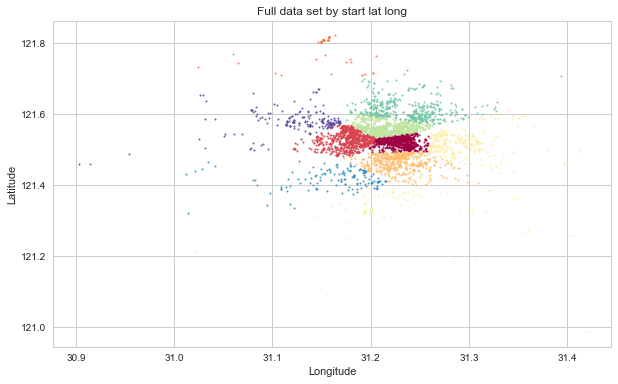

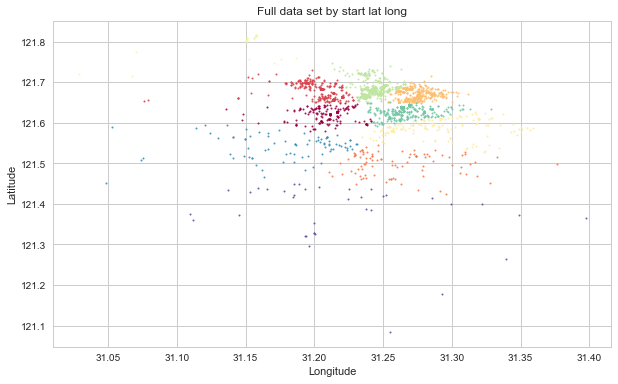

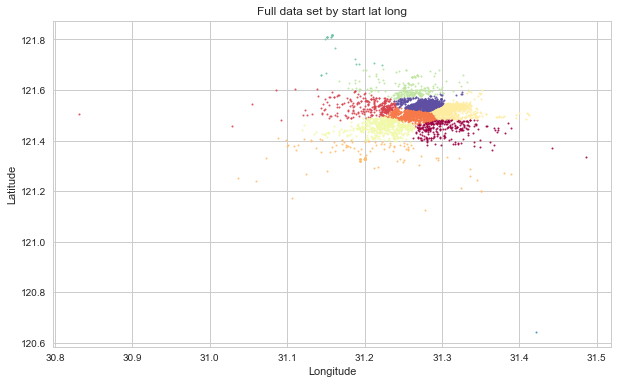

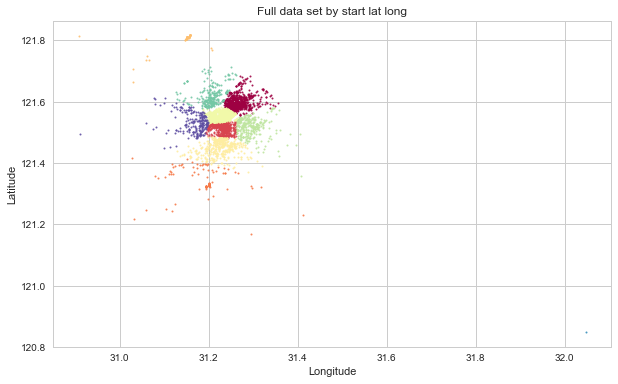

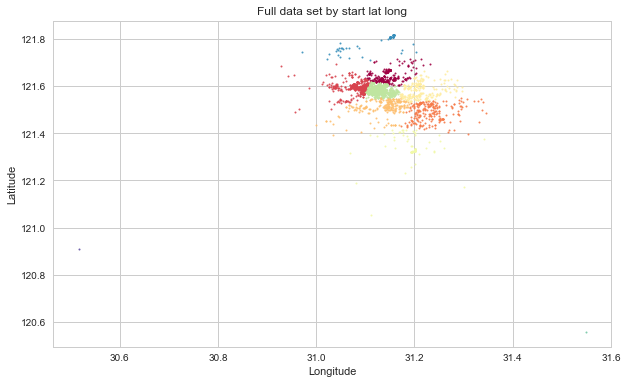

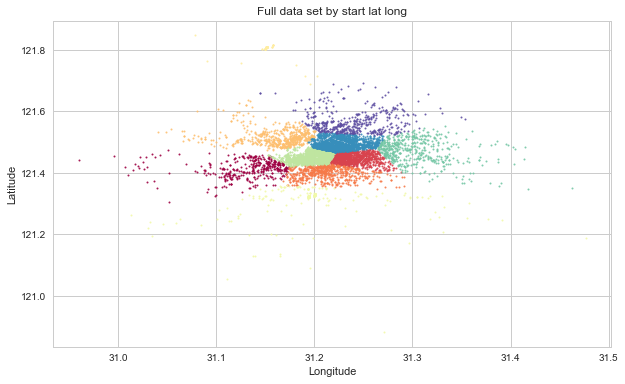

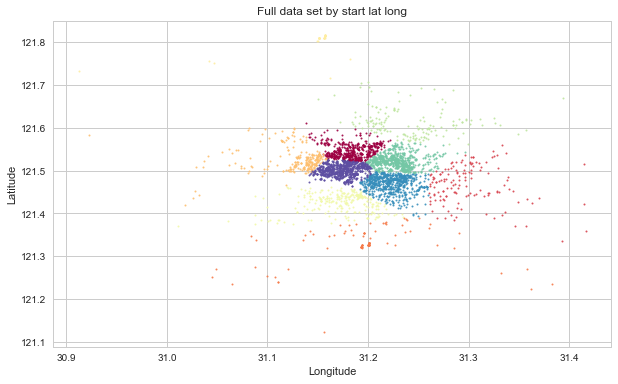

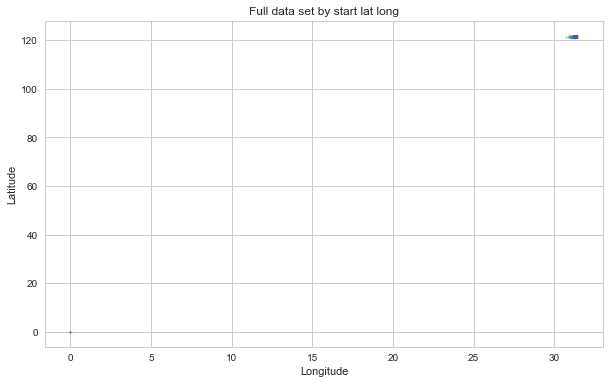

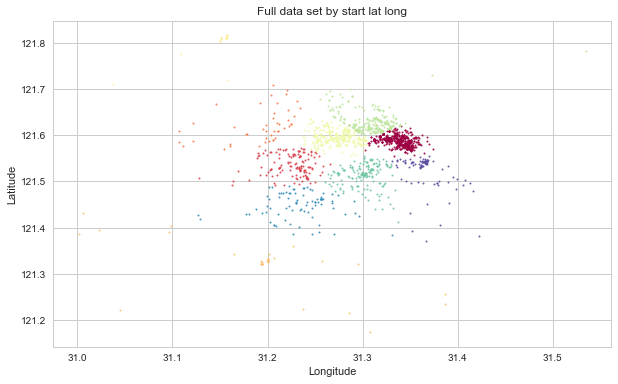

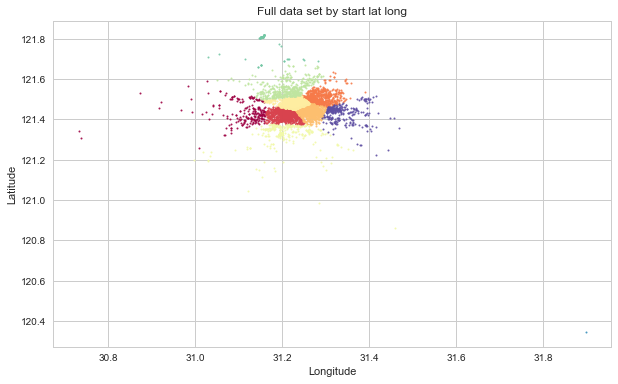

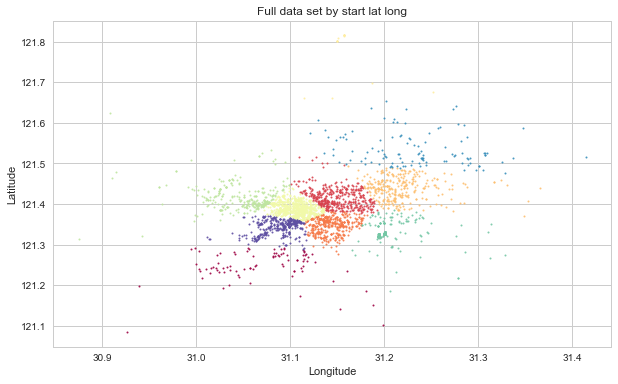

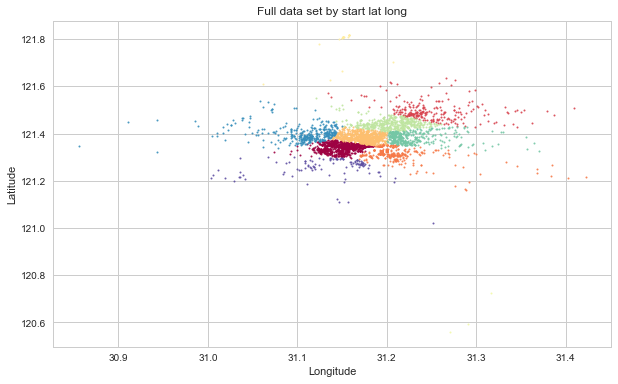

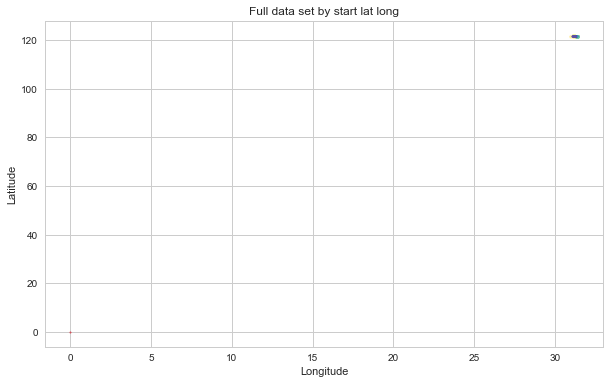

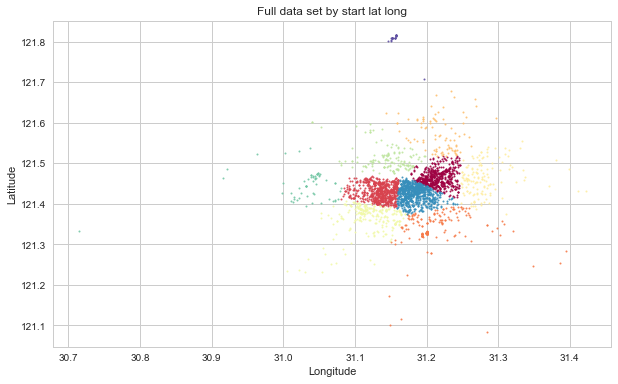

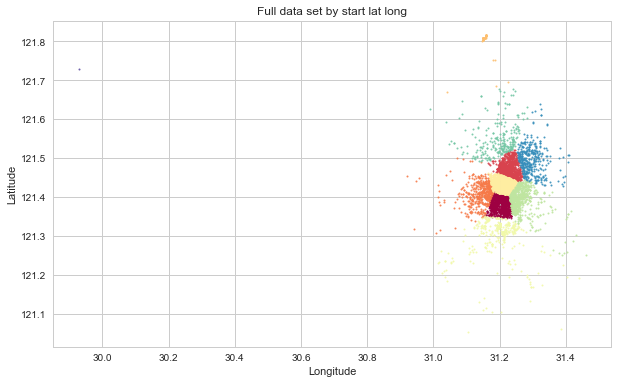

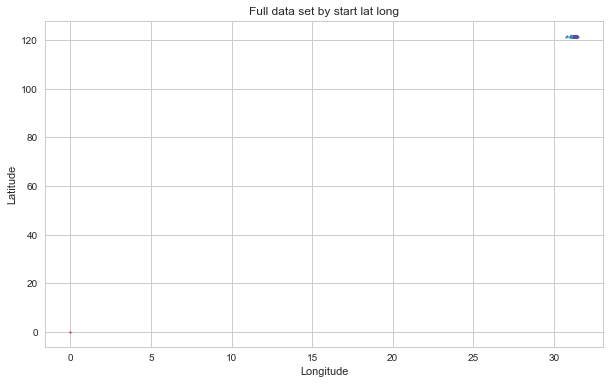

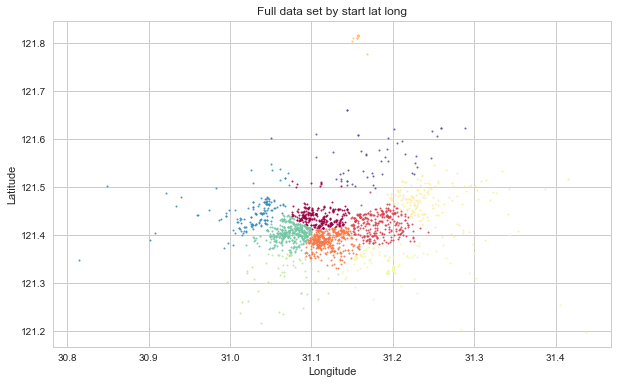

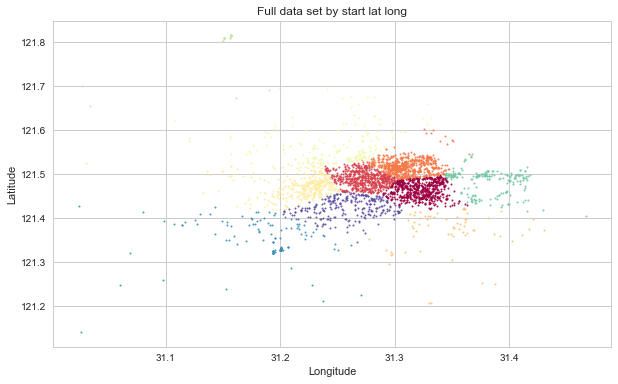

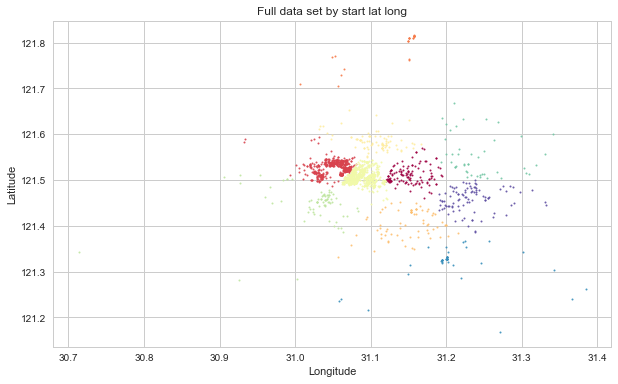

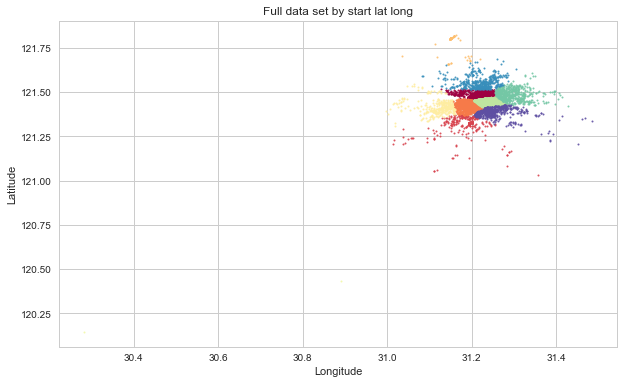

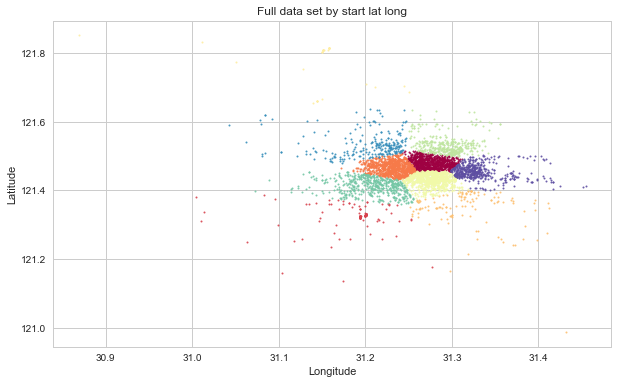

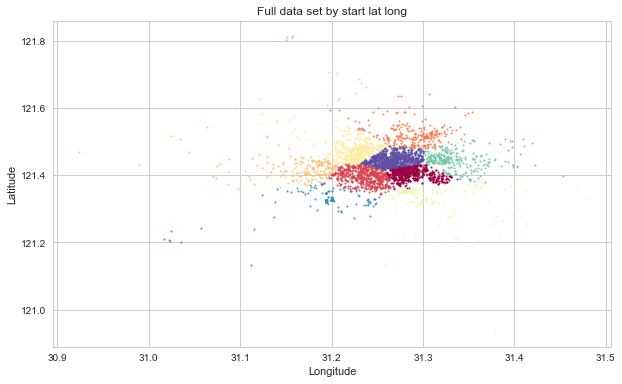

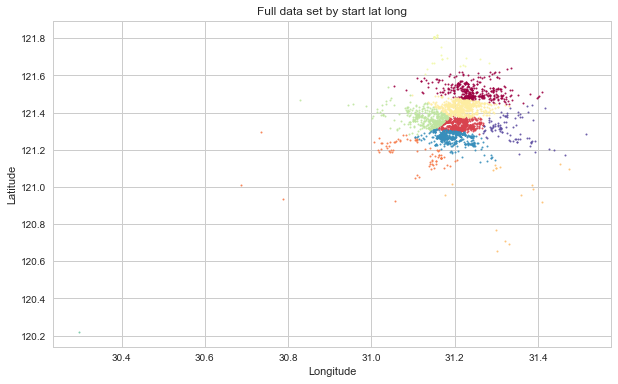

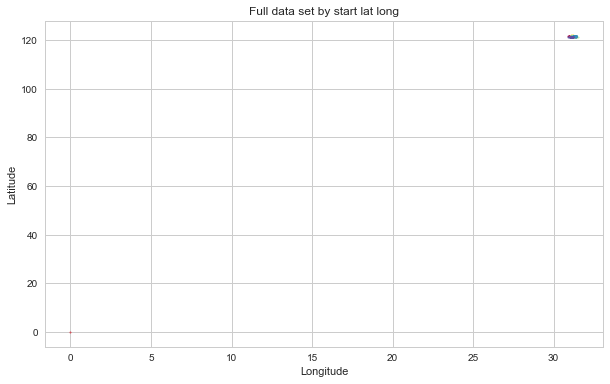

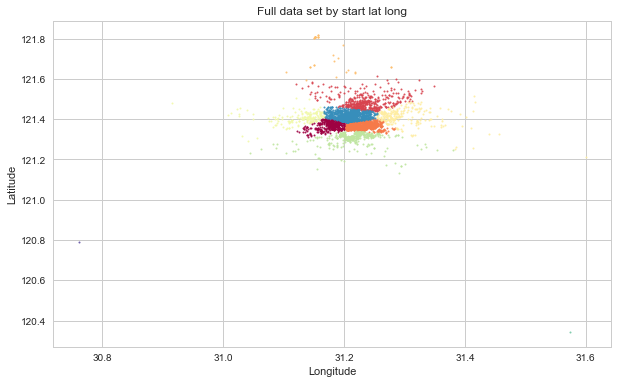

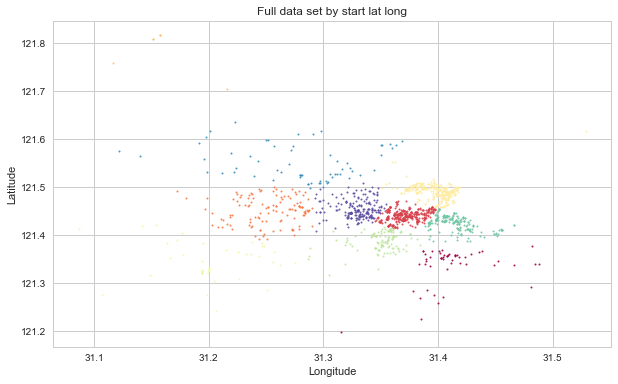

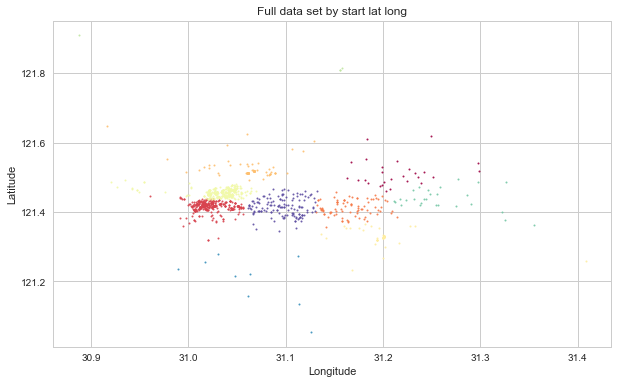

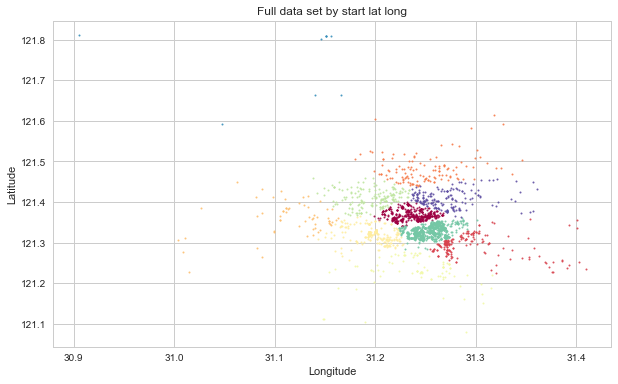

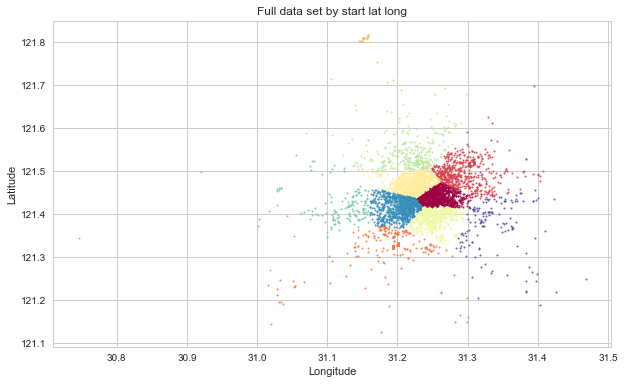

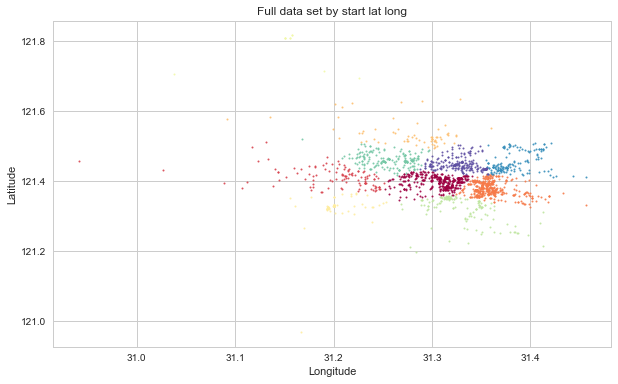

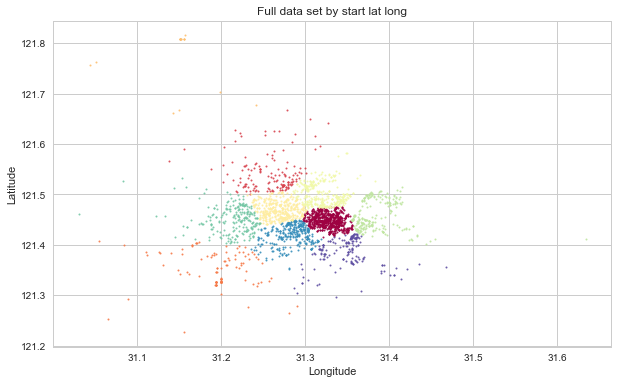

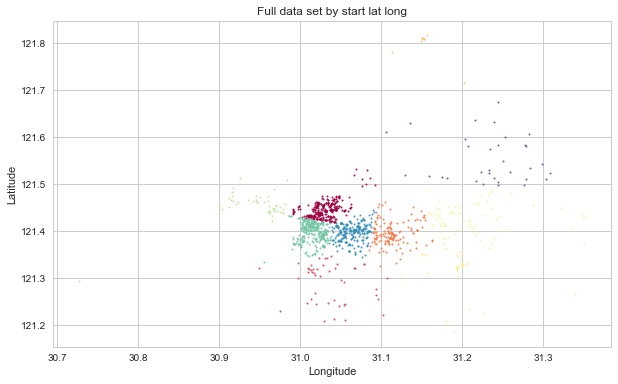

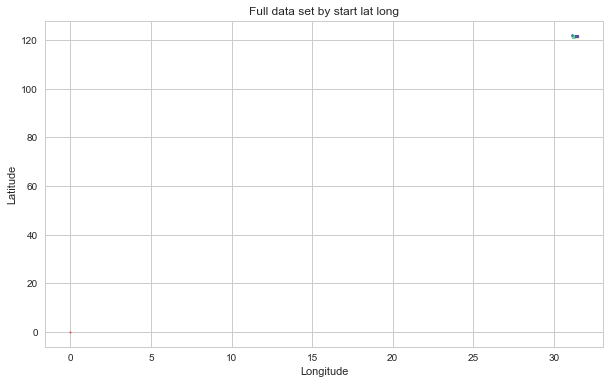

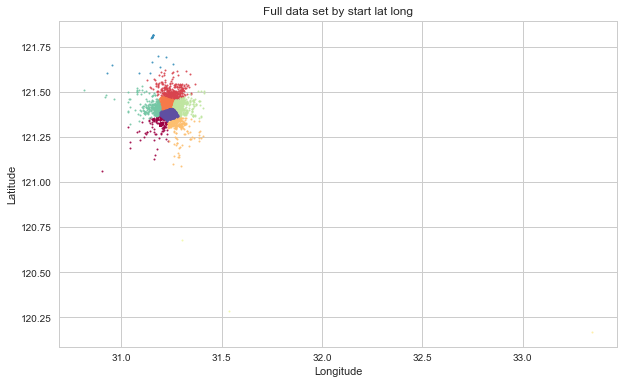

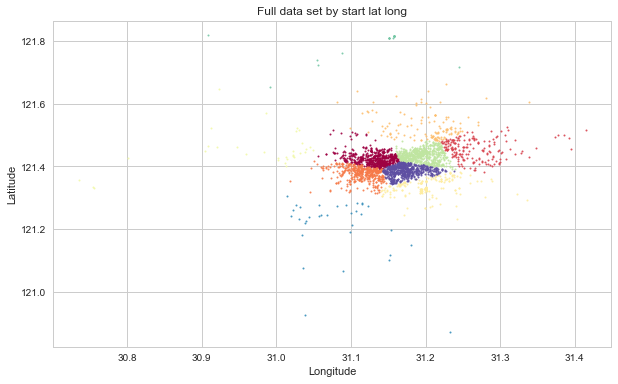

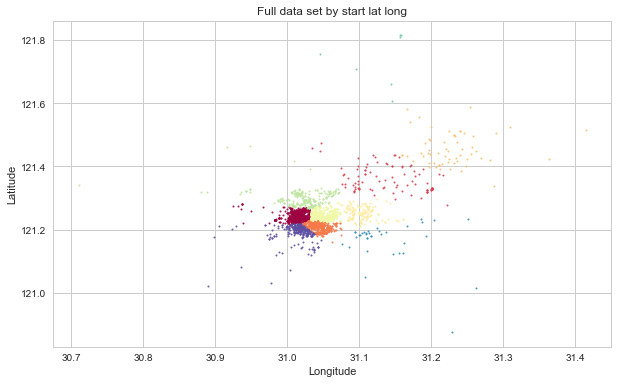

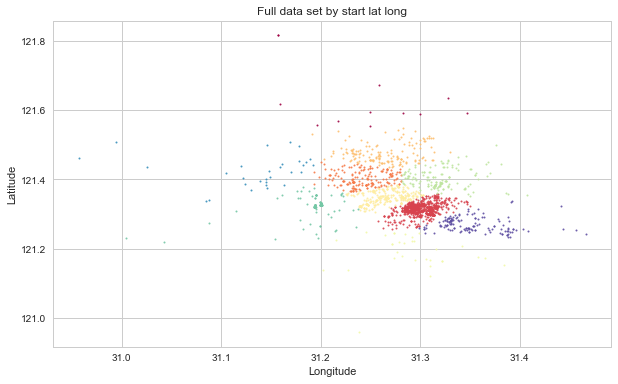

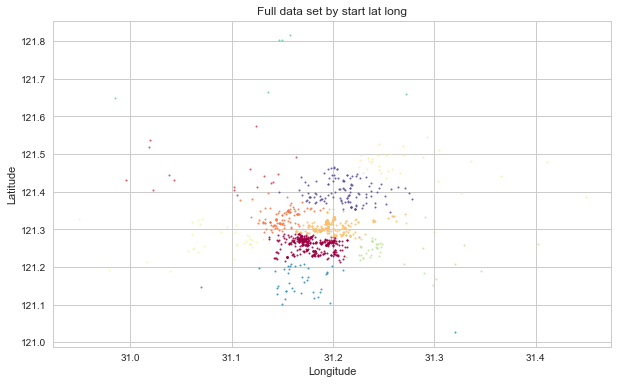

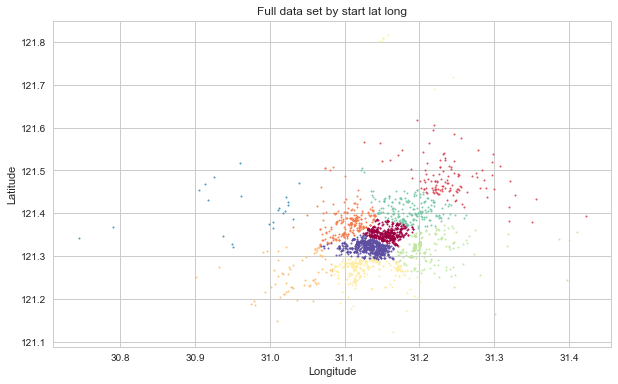

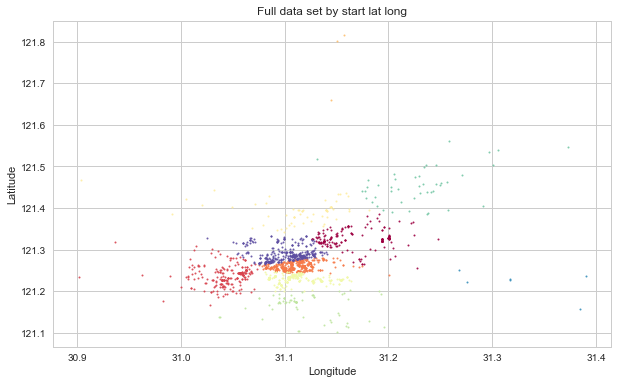

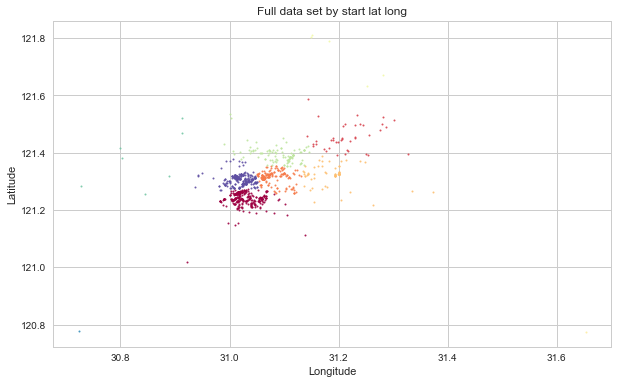

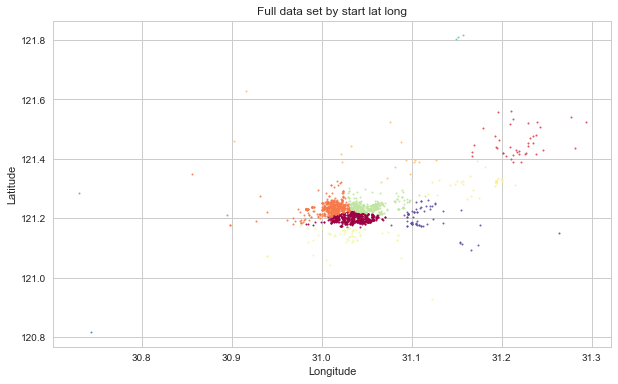

In [56]:
finals=[]
for cluster in df_k["Cluster"].unique():
    target=df_k[df_k["Cluster"]==cluster]
    target_k=df_kmeans(target,10,"dx","dy")
    finals.append(target_k)


Ignore Below

In [1]:
'''
shpFilePath = '/Users/serenazhang/Desktop/didi_project/github/shapefile/shroad'


listx=[]
listy=[]
sf = shapefile.Reader(shpFilePath)
print(len(sf.shapes()))
fig=plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
for shape in sf.shapes():
    points = shape.points
    ap = plt.Polygon(points, fill=False, edgecolor="k")
    ax.add_patch(ap)
print("Displaying Polygons")
plt.show()

# construction of a dctionary field_name:value  
for r in sf.shapeRecords():  
     atr = dict(zip(field_names, r.record))  
plt.figure(num=None, figsize=(20,18), dpi=80, facecolor='w', edgecolor='k')
for sr in test.shapeRecords():
    for xNew,yNew in sr.shape.points:
        listx.append(xNew)
        listy.append(yNew)
plt.plot(listx,listy)
plt.show()

map = Basemap(
        projection='merc', llcrnrlon=70, llcrnrlat=15,
        urcrnrlon=140, urcrnrlat=55, lat_0=15, lon_0=95, resolution='l')
x,y = map(df_shared["start_long"].tolist(),df_shared["start_lat"].tolist())
map.plot(x, y, 'bo', markersize=0.1)
map.drawcoastlines()
map.drawcountries()
map.readshapefile('/Users/serenazhang/Desktop/didi_project/github/shapefile/shroad','shroad')
#map.readshapefile('/Users/serenazhang/Desktop/didi_project/github/china-latest-free/gis.osm_roads_free_1','gis.osm_roads_free_1')
plt.show()

'''

'\nshpFilePath = \'/Users/serenazhang/Desktop/didi_project/github/shapefile/shroad\'\n\n\nlistx=[]\nlisty=[]\nsf = shapefile.Reader(shpFilePath)\nprint(len(sf.shapes()))\nfig=plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor=\'w\', edgecolor=\'k\')\nax = fig.add_subplot(111)\nfor shape in sf.shapes():\n    points = shape.points\n    ap = plt.Polygon(points, fill=False, edgecolor="k")\n    ax.add_patch(ap)\nprint("Displaying Polygons")\nplt.show()\n\n# construction of a dctionary field_name:value  \nfor r in sf.shapeRecords():  \n     atr = dict(zip(field_names, r.record))  \nplt.figure(num=None, figsize=(20,18), dpi=80, facecolor=\'w\', edgecolor=\'k\')\nfor sr in test.shapeRecords():\n    for xNew,yNew in sr.shape.points:\n        listx.append(xNew)\n        listy.append(yNew)\nplt.plot(listx,listy)\nplt.show()\n'